# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к [Data Mining](http://www.wikiwand.com/en/Online_analytical_processing) этот процесс называется Extract-Transform-Load ([ETL](http://www.wikiwand.com/en/Extract,_transform,_load)).

Цель этого задания собрать первые данные о пользователях из обучающей выборки и провести простейший качественный анализ. В ходе решения будут использованы:
1. [numpy](http://www.numpy.org/) -- библиотека для работы с многомерными массивами
2. [pandas](http://pandas.pydata.org/) -- библиотека, позволяющая удобно работать с различными типами данных
3. [requests](http://docs.python-requests.org/en/latest/) -- библиотека, которую можно использовать для вызова HTTP запросов
4. [python-twitter](https://github.com/bear/python-twitter/tree/master/twitter) -- обертка для Twitter API
5. [matplotlib](http://matplotlib.org/) -- библиотека для рисования графиков в python

Первым делом импортируем необходимые библиотеки и убеждаемся, что все установлено.

In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import mpl_toolkits.basemap as bm
import twitter
import requests
import datetime
import dateutil
import csv
import os
import json

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/zhigan/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Чтение исходных данных из файла

Считываем исходные данные из файла в data frame библиотеки pandas. Полученный data frame должен иметь целочисленный ключ и две колонки:
1. uid -- идентификатор пользователя
2. cat -- числовой номер класса

In [2]:
TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])
df_users.head()

,uid,cat
0,40585382,1
1,30005269,0
2,3314758074,0
3,14311688,0
4,110457801,0


Построим распределение целевой переменной. Требуется получить [barchart](http://www.wikiwand.com/en/Bar_chart), в котором высота столбика, соответствующего каждому из классов, пропорциональна количеству пользователей этого класса. По горизонтальной оси отложены классы (positive, negative), а по вертикальной -- количество пользователей.

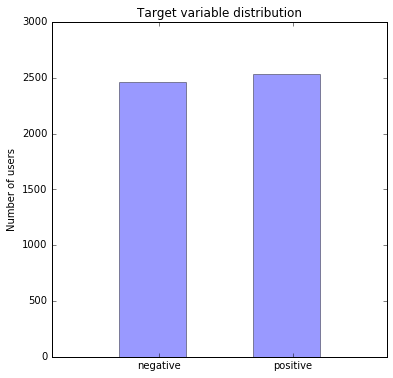

In [3]:
# Compute the distribution of the target variable
counts, bins = np.histogram(df_users_train["cat"], bins=[0,1,2])

# Plot the distribution
pl.figure(figsize=(6,6))
pl.bar(bins[:-1], counts, width=0.5, alpha=0.4)
pl.xticks(bins[:-1] + 0.3, ["negative", "positive"])
pl.xlim(bins[0] - 0.5, bins[-1])
pl.ylabel("Number of users")
pl.title("Target variable distribution")
pl.show()

## Сбор данных

Для того чтобы разработать модель, которая предсказывает значение целевой переменной для произвольного пользователя, недостаточно знать только значения идентификаторов пользоватей. Причина в том, что _user_id_ для пользователя никак не зависит от целевой переменной -- идентификатор генерируется на основании времени регистрации, сервера, обрабатывающего запрос, и номера пользователя ([подробности](https://dev.twitter.com/overview/api/twitter-ids-json-and-snowflake)).

Поэтому нам потребуется загрузить дополнительную информацию о каждом пользователе, иначе говоря провести сбор данных (data collection). Наиболее важную информацию можно загрузить из [Twitter](https://dev.twitter.com/rest/public) [API](http://www.wikiwand.com/en/Representational_state_transfer). При желании можно воспользоваться и другими источниками -- об этом ниже.

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в Twitter в качестве разработчика и создать свое [приложение](https://apps.twitter.com/). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Эти ключи необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в Twitter API можно почитать [по ссылке](https://dev.twitter.com/oauth/application-only), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

In [4]:
CONSUMER_KEY = "niTpjOMrCL3gijR8V2jJFmVJV"
CONSUMER_SECRET = "dEXpPLbaL90MMMNWnVebaMN1c0s5Mtt2DwOEfcq0eCLE1hBoth"

ACCESS_TOKEN_KEY = "2530119974-TNeh6OBqrCUTIgVWBw8jS0YBdLyuYgfcg3ZNAJx"
ACCESS_TOKEN_SECRET = "eYswE94rxldA8E3LaBvqF9A1Fq8zQZJa72BsFcsExdzfM"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Twitter API предоставляет информацию о местонахождении пользователя, но эта информация представлена в текстовом виде, например так:
```
"location": "San Francisco, CA"
```
Такие текстовый описания не слишком удобны для анализа, поэтому наша цель -- получить более структурированную информацию, такую как географические координаты, страна, город и т.д. Для этого удобно использовать геоинформационный сервис, например [GeoNames](http://www.geonames.org/export/web-services.html). Для его использования также необходимо зарегистрироваться, подтвердить регистрацию и включить поддержку API. После этого можно будет посылать запросы для нахождения нужной информации. Например на запрос
```
http://api.geonames.org/search?q="San Francisco, CA"&maxRows=10&username=demo
```
возвращается результат,
```javascript
{
    "totalResultsCount": 2112,
    "geonames": [
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "city, village,...",
            "countryCode": "US",
            "lng": "-122.41942",
            "fcodeName": "seat of a second-order administrative division",
            "toponymName": "San Francisco",
            "fcl": "P",
            "name": "San Francisco",
            "fcode": "PPLA2",
            "geonameId": 5391959,
            "lat": "37.77493",
            "adminName1": "California",
            "population": 805235
        },
        {
            "countryId": "6252001",
            "adminCode1": "CA",
            "countryName": "United States",
            "fclName": "spot, building, farm",
            "countryCode": "US",
            "lng": "-122.3758",
            "fcodeName": "airport",
            "toponymName": "San Francisco International Airport",
            "fcl": "S",
            "name": "San Francisco International Airport",
            "fcode": "AIRP",
            "geonameId": 5391989,
            "lat": "37.61882",
            "adminName1": "California",
            "population": 0
        }
    ]
}
```
из которого легко извлечь нужную информацию.

**Замечание: для запросов необходимо использовать своего пользователя, кроме того количество запросов ограничего 30к в день**.

Первым делом нам понадобится функция, которая возвращает информацию о местоположении для данного текстового запроса. Требуется реализовать функцию get_coordinates_by_location, принимающую на вход строку с местоположением и возвращает кортеж вида (долгота, широта, город).

In [5]:
GEO_USER_NAME = "zhiganoff"

def get_coordinates_by_location(location):    
    data =requests.get('http://api.geonames.org/searchJSON?q=' + location + ',&maxRows=5&username='+GEO_USER_NAME);
    try: 
        if data.json()['totalResultsCount'] != 0 :
            lng = data.json()['geonames'][0]['lng']
            lat = data.json()['geonames'][0]['lat']
            country = data.json()['geonames'][0]['countryName']
        else:
            return(None, None, None)
    except KeyError:
        return(None, None, None)
    return (lat, lng, country)

Следующий шаг -- вызов Twitter API для сбора данных и сохранения их в data frame. После чего data frame c собранными данными совмещается с data frame, содержащим данные исходной обучающей выборки. 

В этой части задания нужно реализовать функцию `get_user_records`, которая принимает на вход прочитанный из файла `data frame` и возвращает список словарей, каждый из которых представляет данные одного пользователя. Для того, чтобы получить из объекта класса [`User`](https://github.com/bear/python-twitter/blob/master/twitter/user.py) словарь в правильном формате, нужно использовать функцию `twitter_user_to_dataframe_record` (4 балла).

Так как скрипт работает существенное время, будем сохранять промежуточный результат.

In [6]:
ts_parser = lambda date_str: dateutil.parser.parse(date_str) if pd.notnull(date_str) else None

user_records = []
tmp_file_name = 'hw_saved_base'
if os.path.exists(tmp_file_name):
    with open(tmp_file_name) as f:
        for line in f:
            try:
                user_records.append(json.loads(line))
            except:
                continue

processed_users = set()
for r in user_records:
    processed_users.add(r['uid'])
    
f = open(tmp_file_name, 'a')
            
def twitter_user_to_dataframe_record(user):
    dt = ts_parser(user.created_at)
    record = {
        "uid": user.id,
        "name": user.name,
        "screen_name": user.screen_name,        
        "created_at": dt.strftime("%Y-%m") if dt else dt,        
        "followers_count": user.followers_count,
        "friends_count": user.friends_count,
        "statuses_count": user.statuses_count,
        "favourites_count": user.favourites_count,
        "listed_count": user.listed_count,
        "verified": user.verified
    }
    
    if user.description is not None and user.description.strip() != "":
        record["description"] = user.description
        
    if user.location is not None and user.location.strip() != "":
        record["location"] = user.location
        record["lat"], record["lon"], record["country"] = get_coordinates_by_location(user.location)
    
    return record


def get_user_records(df):
    user_records = []
    i = 0
    for user_id in df_users['uid']:   # проверка на то, нужно ли скачивать соответствующие id
        if user_id in processed_users:
            i += 1
    for n in range(i, len(df), 100):
        block_id = df['uid'].values[n:n+100].tolist()
        block_users = api.UsersLookup(user_id = block_id)
        for user in block_users:
            user_data = twitter_user_to_dataframe_record(user);
            user_records.append(user_data)
            json.dump(user_data, f)                               # Запись в файл
            f.write('\n')
        print "Downloaded " + str(len(user_records)) + " users"   # Следить на прогрессом
    return user_records

user_records = get_user_records(df_users)

        
print "Creating data frame from loaded data"
df_records = pd.DataFrame(user_records, columns=["uid", "name", "screen_name", "description", "verified", "location", "lat", "lon", "country", "created_at", "followers_count", "friends_count", "statuses_count", "favourites_count", "listed_count"])
print "Merging data frame with the training set"
df_full = pd.merge(df_users, df_records, on="uid", how="left")
print "Finished building data frame"

Downloaded 100 users
Downloaded 199 users
Downloaded 299 users
Downloaded 399 users
Downloaded 499 users
Downloaded 599 users
Downloaded 699 users
Downloaded 799 users
Downloaded 899 users
Downloaded 999 users
Downloaded 1099 users
Downloaded 1199 users
Downloaded 1299 users
Downloaded 1399 users
Downloaded 1499 users
Downloaded 1598 users
Downloaded 1698 users
Downloaded 1798 users
Downloaded 1898 users
Downloaded 1998 users
Downloaded 2097 users
Downloaded 2197 users
Downloaded 2297 users
Downloaded 2396 users
Downloaded 2496 users
Downloaded 2596 users
Downloaded 2696 users
Downloaded 2796 users
Downloaded 2896 users
Downloaded 2995 users
Downloaded 3095 users
Downloaded 3195 users
Downloaded 3295 users
Downloaded 3395 users
Downloaded 3495 users
Downloaded 3595 users
Downloaded 3695 users
Downloaded 3794 users
Downloaded 3893 users
Downloaded 3993 users
Downloaded 4093 users
Downloaded 4192 users
Downloaded 4292 users
Downloaded 4391 users
Downloaded 4491 users
Downloaded 4590 user

## Exploratory Data Analysis

Для того, чтобы лучше понять, как устроена наша обучающая выборка, построим несколько графиков. Сначала построим долю "положительных" пользователей в зависимости от дня создания аккаунта. По горизонтальной оси отложим день создания аккаунта, а по вертикальной -- долю "положительных" пользователей ([подсказка](http://anokhin.github.io/img/hw1_distr.png)). Необходимо дописать код функции count_users. В функции необходимо посчитать пользователей в каждой группе (2 балла).

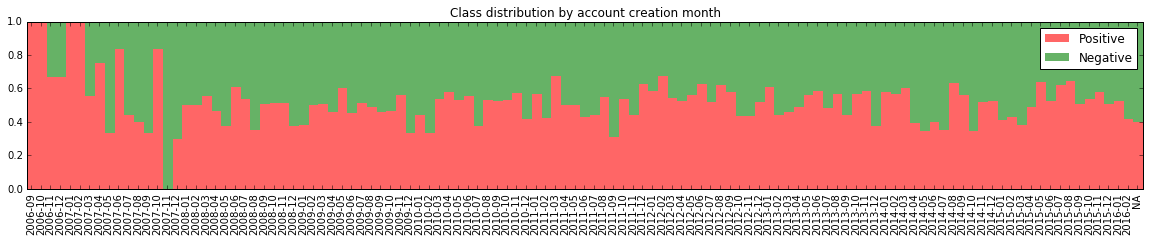

In [7]:
def count_users(grouped):
    dts = []
    count_pos, count_neg = np.zeros(len(grouped)), np.zeros(len(grouped))
    for i in range(len(grouped)):
        month = list(grouped)[i][0]
        dts.append(month)
        for count in grouped.get_group(month)['cat']:
            if count == 0:
                count_neg[i] += 1
            elif count == 1:
                count_pos[i] += 1 
    return count_pos, count_neg, dts


grouped = df_full.groupby(map(lambda dt: dt if pd.notnull(dt) else "NA", df_full["created_at"]))
count_pos, count_neg, dts = count_users(grouped)
    
fraction_pos = count_pos / (count_pos + count_neg + 1e-10)
fraction_neg = 1 - fraction_pos

sort_ind = np.argsort(dts)
    
pl.figure(figsize=(20, 3))
pl.bar(np.arange(len(dts)), fraction_pos[sort_ind], width=1.0, color='red', alpha=0.6, linewidth=0, label="Positive")
pl.bar(np.arange(len(dts)), fraction_neg[sort_ind], bottom=fraction_pos[sort_ind], width=1.0, color='green', alpha=0.6, linewidth=0, label="Negative")
pl.xticks(np.arange(len(dts)) + 0.4, sorted(dts), rotation=90)
pl.title("Class distribution by account creation month")
pl.xlim(0, len(dts))
pl.legend()
pl.show()

Видно, что доля "положительных" аккаунтов в выборке растет с увеличением времени. Посмотрим, где живут пользователи положительной и отрицательной категории. Для этого отметим на карте каждого положительного пользователя красным, а отрицательного -- зеленым цветом ([подсказка](http://anokhin.github.io/img/hw1_map.png)). Необходимо реализовать функцию plot_points_on_map. В функции необходимо отобразить на карте пользователей из разных классов (2 балла).

/home/zhigan/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


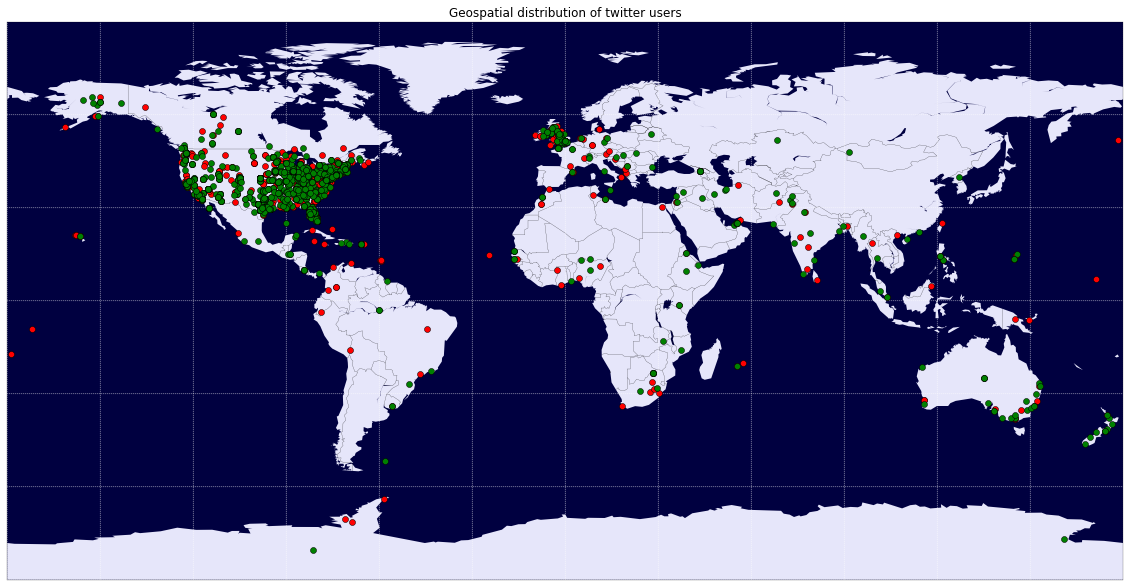

In [9]:
pl.figure(figsize=(20,12))

m = bm.Basemap(projection='cyl', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')

m.drawcountries(linewidth=0.2)
m.fillcontinents(color='lavender', lake_color='#000040')
m.drawmapboundary(linewidth=0.2, fill_color='#000040')
m.drawparallels(np.arange(-90,90,30),labels=[0,0,0,0], color='white', linewidth=0.5)
m.drawmeridians(np.arange(0,360,30),labels=[0,0,0,0], color='white', linewidth=0.5)

def plot_points_on_map(df_full):
    # Просто вывел, не креативно
    lon_pos, lon_neg, lat_pos, lat_neg = [], [], [], []
    for i in range(len(df_full)):
        if df_full["cat"][i] == 1:
            lon_pos.append(df_full["lon"][i])
            lat_pos.append(df_full["lat"][i])
        if df_full["cat"][i] == 0:
            lon_neg.append(df_full["lon"][i])
            lat_neg.append(df_full["lat"][i])
    x,y = m(lon_pos, lat_pos)
    m.plot(x, y, 'o', color = 'r')
    x,y = m(lon_neg, lat_neg)
    m.plot(x, y, 'o', color = 'g')
    return

plot_points_on_map(df_full)

pl.title("Geospatial distribution of twitter users")
pl.legend()
pl.show()

В последней картинке есть проблема: сервис геоинформации определяет координаты с точностью до города, поэтому точки, соответствующте нескольким пользователям, могут накладываться. Предложите и реализуйте способ, позволяющий справиться с этой проблемой (2 балла).

Смотрим на полученный data frame и сохраняем его в .csv файл.

В поле ниже необходимо словами описать, как было улучшено изображение (описание необходимо для корректной проверки задания).

In [10]:
OUT_FILE_PATH = "hw1_out_Zhiganov_Roman.csv"
print "Saving output data frame to %s" % OUT_FILE_PATH
df_full.to_csv(OUT_FILE_PATH, sep="\t", index=False, encoding="utf-8", quoting=csv.QUOTE_NONNUMERIC)
df_full.head()

Saving output data frame to hw1_out_Zhiganov_Roman.csv


,uid,cat,name,screen_name,description,verified,location,lat,lon,country,created_at,followers_count,friends_count,statuses_count,favourites_count,listed_count
0,40585382,1,Reverend Sue,ReverendSue,Retired Interfaith Minister. Activist. Equalit...,False,United States,39.76,-98.5,United States,2009-05,7614,4284,50614,787,417
1,30005269,0,Ryan Wrasse,RWrasse,Communications Director for @SenJohnThune | Ge...,False,Capitol Hill,15.20825,145.75313,Northern Mariana Islands,2009-04,1912,1240,7145,127,96
2,3314758074,0,Campaign Trump,Campaign_Trump,#Trump for President. Indp. Local & Internatio...,False,"Houston, TX",29.76328,-95.36327,United States,2015-08,19474,12709,1190,7212,173
3,14311688,0,Bernard Whitman,BernardWhitman,"Democratic strategist, pollster, and corporate...",False,New York,40.71427,-74.00597,United States,2008-04,1753,1292,7342,157,110
4,110457801,0,Carson Ingle,caingle,Writer for @AthleteSpeakers & @NOPACTalent. 10...,False,Orlando aka The City Beautiful,None,None,None,2010-02,1468,1188,37135,3313,76
